In [40]:
# http://blog.varunajayasiri.com/numpy_lstm.html

### Imports

In [30]:
%%time
import numpy as np
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
plt.style.use('seaborn-white')

Wall time: 125 ms


### Read and process data


In [1]:
data = open('shakespear.txt', 'r').read()
# http://cs.stanford.edu/people/karpathy/char-rnn/shakespear.txt

In [4]:
chars = list(set(data)) # Alphabetize
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)} # key: char, value: count
idx_to_char = {i:ch for i,ch in enumerate(chars)} # key: count, value: char

data has 99993 characters, 62 unique


### Parameters

In [13]:
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

### Activation Functions and Derivatives

##### Sigmoid

\begin{align}
\sigma(x) &= \frac{1}{1 + e^{-x}}\\
\frac{d\sigma(x)}{dx} &= \sigma(x) \cdot (1 - \sigma(x))
\end{align}

##### Tanh

\begin{align}
\frac{d\text{tanh}(x)}{dx} &= 1 - \text{tanh}^2(x)
\end{align}

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

### Initialize weights

We use random weights with normal distribution (0, weight_sd) for tanh activation function and (0.5, weight_sd) for sigmoid activation function.  

Biases are initialized to zeros.  

Formulae for LSTM are shown below.  

In [14]:
W_f = np.random.randn(H_size, z_size) * weight_sd + 0.5
b_f = np.zeros((H_size, 1))

W_i = np.random.randn(H_size, z_size) * weight_sd + 0.5
b_i = np.zeros((H_size, 1))

W_C = np.random.randn(H_size, z_size) * weight_sd
b_C = np.zeros((H_size, 1))

W_o = np.random.randn(H_size, z_size) * weight_sd + 0.5
b_o = np.zeros((H_size, 1))

#For final layer to predict the next character
W_y = np.random.randn(X_size, H_size) * weight_sd
b_y = np.zeros((X_size, 1))

In [15]:
dW_f = np.zeros_like(W_f)
dW_i = np.zeros_like(W_i)
dW_C = np.zeros_like(W_C)

dW_o = np.zeros_like(W_o)
dW_y = np.zeros_like(W_y)

db_f = np.zeros_like(b_f)
db_i = np.zeros_like(b_i)
db_C = np.zeros_like(b_C)

db_o = np.zeros_like(b_o)
db_y = np.zeros_like(b_y)

### Forward pass

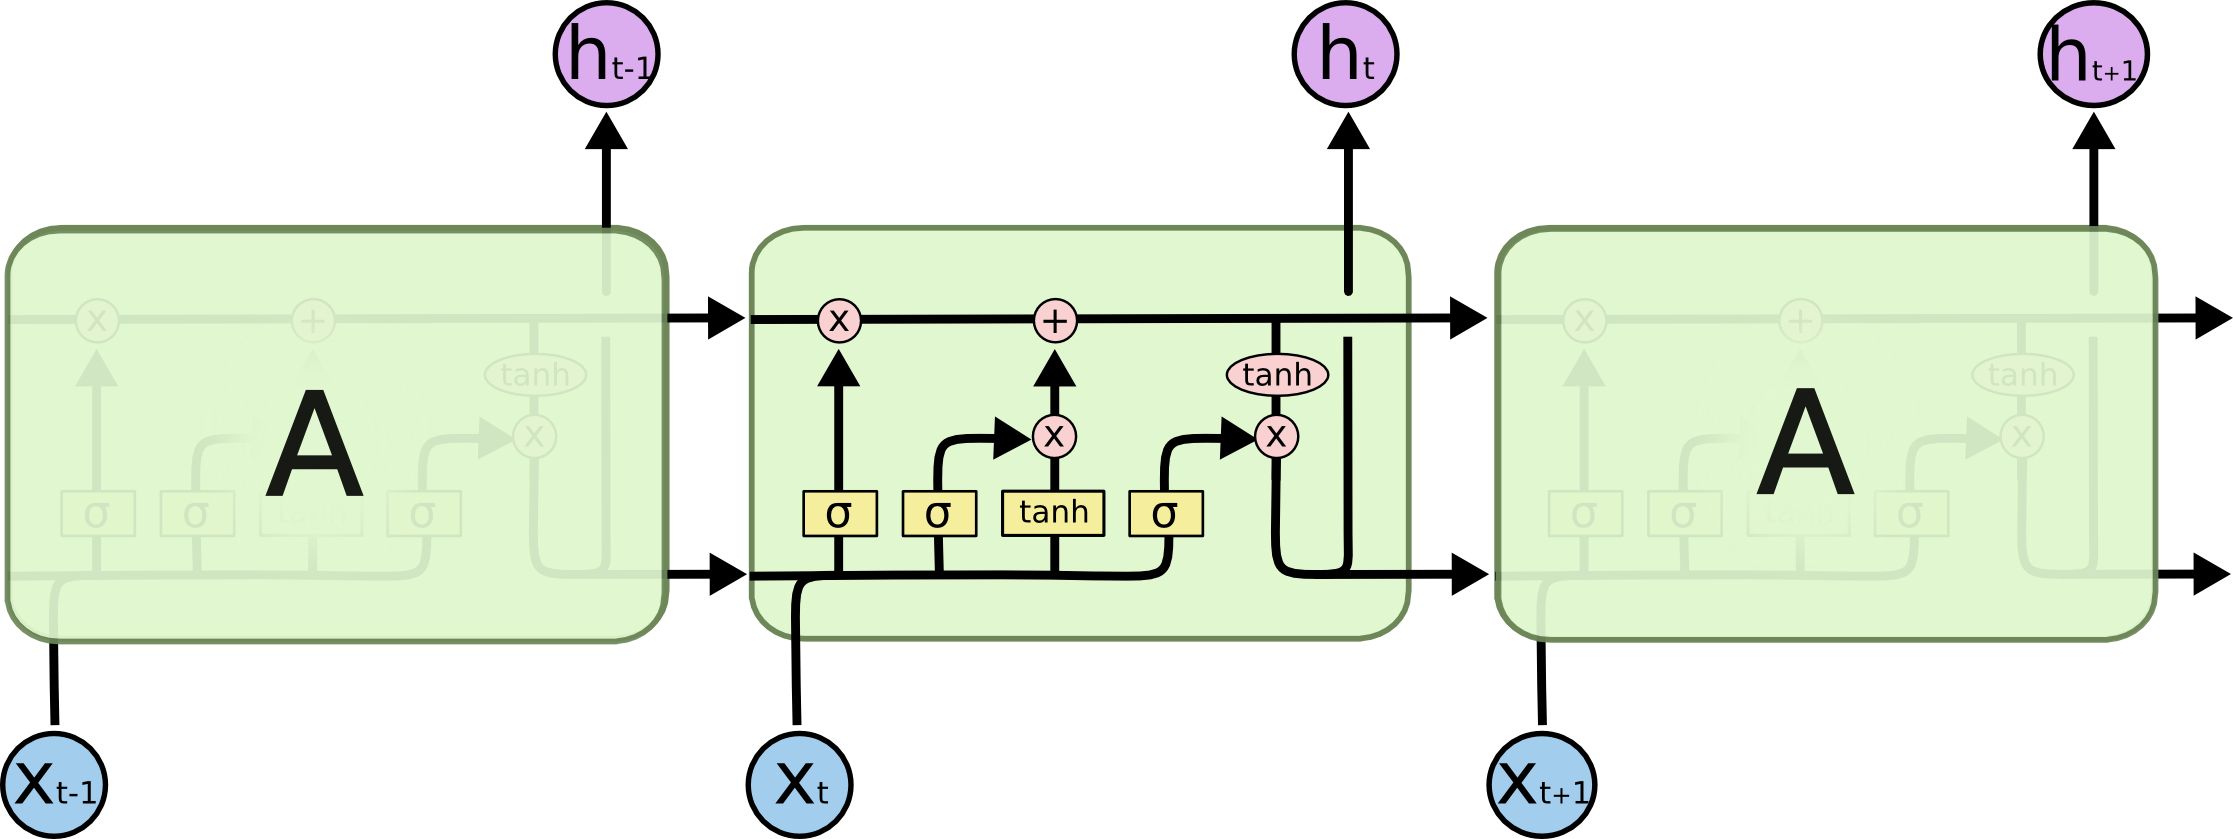

In [31]:
display.display(display.Image('LSTM3-chain.png'))

Image taken from 'Understanding LSTM Networks'. Please read the article for a good explanation of LSTMs.  

Understanding LSTM Networks: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

#### Concatenation of $h_{t-1}$ and $x_t$
\begin{align}
z & = [h_{t-1}, x_t] \\
\end{align}

#### LSTM functions
\begin{align}
f_t & = \sigma(W_f \cdot z + b_f) \\
i_t & = \sigma(W_i \cdot z + b_i) \\
\bar{C}_t & = tanh(W_C \cdot z + b_C) \\
C_t & = f_t * C_{t-1} + i_t * \bar{C}_t \\
o_t & = \sigma(W_o \cdot z + b_t) \\
h_t &= o_t * tanh(C_t) \\
\end{align}

#### Logits
\begin{align}
y_t &= W_y \cdot h_t + b_y \\
\end{align}

#### Softmax
\begin{align}
\hat{p_t} &= \text{softmax}(y_t)
\end{align}


$\mathbf{\hat{p_t}}$ is <code>p</code> in code and $\mathbf{p_t}$ is <code>targets</code>

In [20]:
def forward(x, h_prev, C_prev):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)

    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(W_f, z) + b_f)
    i = sigmoid(np.dot(W_i, z) + b_i)
    C_bar = tanh(np.dot(W_C, z) + b_C)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(W_o, z) + b_o)
    h = o * tanh(C)

    y = np.dot(W_y, h) + b_y
    p = np.exp(y) / np.sum(np.exp(y))

    return z, f, i, C_bar, C, o, h, y, p

### Backward pass

#### Loss
\begin{align}
\mathcal{L} &= -\sum p_{t,j} log \hat{p_{t,j}} \\
\end{align}

#### Gradients
\begin{align}
dy_t &= \hat{p_t} - p_t \\
dh_t &= dh'_{t+1} + W_y^T \cdot d_y \\
do_t &= dh_t * \text{tanh}(C_t) \\
dC_t &= dC'_{t+1} + dh_t * o_t * (1 - \text{tanh}^2(C_t))\\
d\bar{C}_t &= dC_t * i_t \\
di_t &= dC_t * \bar{C}_t \\
df_t &= dC_t * C_{t-1} \\
dz_t &= W_f^T \cdot df_t + W_i^T \cdot di_t + W_C^T \cdot d\bar{C}_t + W_o^T \cdot do_t \\
[dh'_t, dx_t] &= dz_t \\
dC'_t &= f * dC_t
\end{align}


- <code>target</code> is target character index $\mathbf{p_t}$
- <code>dh_next</code> is $\mathbf{dh_{t+1}}$ (size H x 1)
- <code>dC_next</code> is $\mathbf{dC_{t+1}}$ (size H x 1)
- <code>C_prev</code> is $\mathbf{C_{t-1}}$ (size H x 1)
- <em>Returns</em> $\mathbf{dh_t}$ and $\mathbf{dC_t}$

In [21]:
def backward(target, dh_next, dC_next, C_prev, z, f, i, C_bar, C, o, h, y, p):

    global dW_f, dW_i, dW_C, dW_o, dW_y
    global db_f, db_i, db_C, db_o, db_y

    assert z.shape == (X_size + H_size, 1)
    assert y.shape == (X_size, 1)
    assert p.shape == (X_size, 1)

    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)

    dy = np.copy(p)
    dy[target] -= 1

    dW_y += np.dot(dy, h.T)
    db_y += dy

    dh = np.dot(W_y.T, dy)
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    dW_o += np.dot(do, z.T)
    db_o += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dC_bar * dtanh(C_bar)
    dW_C += np.dot(dC_bar, z.T)
    db_C += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    dW_i += np.dot(di, z.T)
    db_i += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    dW_f += np.dot(df, z.T)
    db_f += df

    dz = np.dot(W_f.T, df) \
        + np.dot(W_i.T, di) \
        + np.dot(W_C.T, dC_bar) \
        + np.dot(W_o.T, do)
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC

    return dh_prev, dC_prev

### Forward Backward Pass

Calculate and store the values in forward pass. Accumulate gradients in backward pass and clip gradients to avoid exploding gradients.   

- <code>input</code>, <code>target</code> are list of integers, with character indexes.  
- <code>h_prev</code> is the array of initial <code>h</code> at $\mathbf{h_-1}$ (size H x 1)  
- <code>C_prev</code> is the array of initial <code>C</code> at $\mathbf{C_-1}$ (size H x 1)  
- <em>Returns</em> loss, final $\mathbf{h_T}$ and $\mathbf{C_T}$

In [22]:
def forward_backward(inputs, targets, h_prev, C_prev):
    # To store the values for each time step
    x_s, z_s, f_s, i_s, C_bar_s, C_s, o_s, h_s, y_s, p_s = {}, {}, {}, {}, {}, {}, {}, {}, {}, {}

    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)

    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character

        z_s[t], f_s[t], i_s[t], C_bar_s[t], C_s[t], o_s[t], h_s[t], y_s[t], p_s[t] \
            = forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass

        loss += -np.log(p_s[t][targets[t], 0]) # Loss for at t


    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        dparam.fill(0)

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = backward(target = targets[t], dh_next = dh_next, dC_next = dC_next, C_prev = C_s[t-1],
                 z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t], C = C_s[t], o = o_s[t],
                 h = h_s[t], y = y_s[t], p = p_s[t])

    # Clip gradients to mitigate exploding gradients
    for dparam in [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y]:
        np.clip(dparam, -1, 1, out=dparam)

    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

### Sample the next character

In [23]:
def sample(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []

    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

### Training (Adagrad)

\begin{align}
w = w - \eta\frac{dw}{\sum dw_{\tau}^2}
\end{align}

In [32]:
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss

    # Get predictions for 200 letters with current model
    display.clear_output(wait=True)

    sample_idx = sample(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    display.display(plt.gcf())

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

Memory variables for Adagrad

In [33]:
mW_f = np.zeros_like(W_f)
mW_i = np.zeros_like(W_i)
mW_C = np.zeros_like(W_C)
mW_o = np.zeros_like(W_o)
mW_y = np.zeros_like(W_y)

mb_f = np.zeros_like(b_f)
mb_i = np.zeros_like(b_i)
mb_C = np.zeros_like(b_C)
mb_o = np.zeros_like(b_o)
mb_y = np.zeros_like(b_y)

In [34]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, p = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

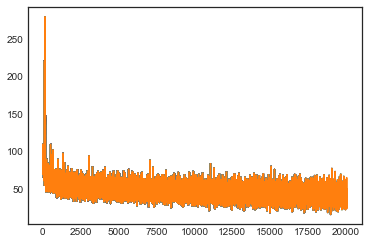

----
 ill tay Lost every man.

FORK:
Bet of dimon's flow your fares finstr.

First Mertemy:
Hall it disthess to thee I have love se.
But Canude, and valoust: what kind inpurR:
Hear's my swould, that they pu 
----
iter 20067, loss 41.962231
Wall time: 10min 42s


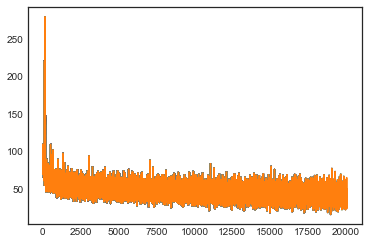

In [35]:
%%time
while True:
    # Try catch for interruption
    try:
        # Reset
        if p + T_steps >= len(data) or iteration == 0:
            g_h_prev = np.zeros((H_size, 1))
            g_C_prev = np.zeros((H_size, 1))
            p = 0


        inputs = [char_to_idx[ch] for ch in data[p: p + T_steps]]
        targets = [char_to_idx[ch] for ch in data[p + 1: p + T_steps + 1]]

        loss, g_h_prev, g_C_prev =  forward_backward(inputs, targets, g_h_prev, g_C_prev)
        smooth_loss = smooth_loss * 0.999 + loss * 0.001

        # Print every hundred steps
        if iteration % 100 == 0:
            update_status(inputs, g_h_prev, g_C_prev)


        # Update weights
        for param, dparam, mem in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                      [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                      [mW_f, mW_i, mW_C, mW_o, mW_y, mb_f, mb_i, mb_C, mb_o, mb_y]):
            mem += dparam * dparam # Calculate sum of gradients
            #print(learning_rate * dparam)
            param += -(learning_rate * dparam / np.sqrt(mem + 1e-8))

        plot_iter = np.append(plot_iter, [iteration])
        plot_loss = np.append(plot_loss, [loss])

        p += T_steps
        iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

### Gradient Check

Approximate the numerical gradients by changing parameters and running the model. Check if the approximated gradients are equal to the computed analytical gradients (by backpropagation).

Try this on <code>num_checks</code> individual paramters picked randomly for each weight matrix and bias vector.

In [36]:
from random import uniform

In [37]:
def gradient_check(inputs, target, h_prev, C_prev):
    global W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y
    global dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y

    num_checks = 10 # Number of parameters to test
    delta = 1e-5 # The change to make on the parameter

    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)

    for param, dparam, name in zip([W_f, W_i, W_C, W_o, W_y, b_f, b_i, b_C, b_o, b_y],
                                 [dW_f, dW_i, dW_C, dW_o, dW_y, db_f, db_i, db_C, db_o, db_y],
                                 ['W_f', 'W_i', 'W_C', 'W_o', 'W_y', 'b_f', 'b_i', 'b_C', 'b_o', 'b_y']):
        assert param.shape == dparam.shape
        dparam_copy = np.copy(dparam) #Make a copy because this will get modified

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0,param.size))

            # evaluate cost at [x + delta] and [x - delta]
            old_val = param.flat[rnd_idx]
            param.flat[rnd_idx] = old_val + delta
            loss_plus_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
            param.flat[rnd_idx] = old_val - delta
            loss_mins_delta, _, _ = forward_backward(inputs, targets, h_prev, C_prev)
            param.flat[rnd_idx] = old_val

            grad_analytical = dparam_copy.flat[rnd_idx]
            grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
            # Clip numerical error because grad_analytical is clipped
            [grad_numerical] = np.clip([grad_numerical], -1, 1)


            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum

            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e' % (name, grad_numerical, grad_analytical, rel_error))

In [39]:
gradient_check(inputs, targets, g_h_prev, g_C_prev)

W_i (3.709033e-07, 3.714525e-07) => 7.388321e-04
W_y (-8.107897e-05, -8.107915e-05) => 1.153923e-06
W_y (-5.503438e-05, -5.503486e-05) => 4.356360e-06
W_y (-7.986500e-07, -7.985561e-07) => 5.875499e-05
W_y (-6.760814e-07, -6.763808e-07) => 2.211975e-04
W_y (-6.330048e-05, -6.329980e-05) => 5.333087e-06
b_f (-5.882217e-02, -5.882236e-02) => 1.639719e-06
b_f (1.730434e-03, 1.730427e-03) => 1.931272e-06
b_C (2.980705e-02, 2.980730e-02) => 4.260634e-06
b_C (-1.869509e-05, -1.869527e-05) => 4.917696e-06
